Found 2195 files belonging to 10 classes.
Found 2306 files belonging to 10 classes.
Found 285 files belonging to 10 classes.
Epoch 1/120
11/69 ━━━━━━━━━━━━━━━━━━━━ 51s 887ms/step - accuracy: 0.1294 - loss: 10.1625

KeyboardInterrupt: 

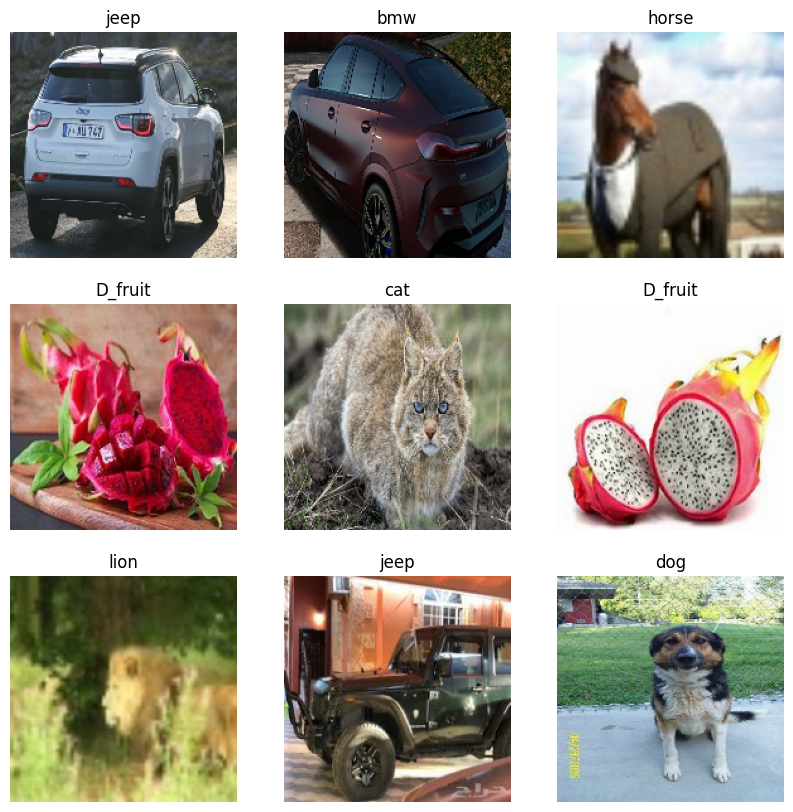

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from PIL import Image

# Paths to datasets
data_path_train = 'datasets/train'
data_path_test = 'datasets/test'
data_path_val = 'datasets/validation'

# Validate and convert images
def validate_and_convert_images(directory):
    supported_formats = ['JPEG', 'PNG', 'GIF', 'BMP']
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    if img.format not in supported_formats:
                        print(f"Unsupported format: {file_path} - {img.format}")
                        # Convert to a supported format
                        new_file_path = os.path.splitext(file_path)[0] + '.png'
                        img.convert('RGB').save(new_file_path, 'PNG')
                        os.remove(file_path)
                        print(f"Converted {file_path} to {new_file_path}")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Validate and convert images in all dataset directories
validate_and_convert_images(data_path_train)
validate_and_convert_images(data_path_val)
validate_and_convert_images(data_path_test)

# Image dimensions
img_width = 180
img_height = 180

# Load datasets
data_train = tf.keras.utils.image_dataset_from_directory(
    data_path_train,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32)

data_val = tf.keras.utils.image_dataset_from_directory(
    data_path_val,
    shuffle=False,
    image_size=(img_width, img_height),
    batch_size=32)

data_test = tf.keras.utils.image_dataset_from_directory(
    data_path_test,
    shuffle=False,
    image_size=(img_width, img_height),
    batch_size=32)

# Class names
data_cat = data_train.class_names

# Display some images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

# Data augmentation layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        layers.RandomTranslation(0.2, 0.2),
    ]
)

# Enhanced Model definition with more layers and adjusted regularization
model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(len(data_cat), activation='softmax')
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Callback for saving the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',  # changed from val_accuracy to val_loss
    save_best_only=True,
    mode='min'
)

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)  # reduced patience

# Callback for reducing learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=0.00001)  # more aggressive reduction

# Train the model with early stopping and learning rate reduction
history = model.fit(data_train, validation_data=data_val, epochs=120,
                    callbacks=[checkpoint, early_stopping, reduce_lr])


In [ ]:

# Save the model
model.save('image_classification_test_5.keras')

# Plot training and validation accuracy and loss
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Load the saved model



In [10]:
loaded_model = tf.keras.models.load_model('image_classification_test_2.keras')
# Predict on a single image
image_path = 'datasets/test/apple/195.jpg'
image = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
img_arr = tf.keras.utils.img_to_array(image)
img_bat = tf.expand_dims(img_arr, 0)

predict = loaded_model.predict(img_bat)
score = tf.nn.softmax(predict[0])

print(f'The given image is {data_cat[np.argmax(score)]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
The given image is apple
